In [ ]:
%pip install keras-tuner --upgrade

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
# import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import subprocess

In [ ]:
# subprocess.run(['java', '-jar', 'createDataset.jar', '-ss', 'RandomConfiguration', '-m', '100', '-fm', './bcs_v1.xml', '-c', './products.csv'], capture_output=True)

In [2]:
# get dataset
dataset = pd.read_csv("products.csv")
dataset = dataset.sample(frac=1)
# mandatories = ['BodyComfortSystem', 'Electric', 'ChargingBehaviour', 'ElectroMotor', 'BatterySystem', 'DoorSystem', 'EM', 'PW', 'FP', 'PW_Control', 'Electrical', 'HMI', 'Wiper', 'Wiper_Quality', 'Sensor']
# dataset = dataset.drop(mandatories, axis=1)
dataset_features = dataset.copy()
dataset_labels = dataset_features.pop('MTTF')

In [ ]:
sns.pairplot(dataset, hue="MTTF")

In [ ]:
# normalize dataset (MinMaxScale)
features_max = dataset_features.max()
labels_max = dataset_labels.max()
dataset_features /= features_max
dataset_labels /= dataset_labels.max()

In [3]:
# split dataset train (2/3) test (1/3)
x, x_test, y, y_test = train_test_split(dataset_features, dataset_labels, test_size=0.33)

In [4]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x, y)


RandomForestRegressor()

<BarContainer object of 50 artists>

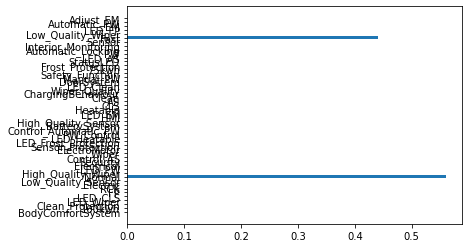

In [5]:
plt.barh(dataset_features.columns, rf.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

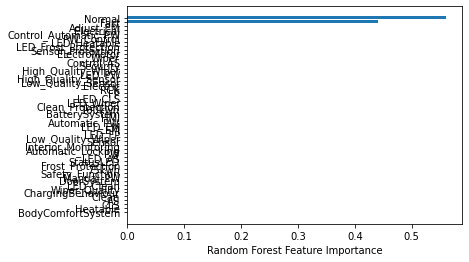

In [8]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(dataset_features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [9]:
perm_importance = permutation_importance(rf, x_test, y_test)


Text(0.5, 0, 'Permutation Importance')

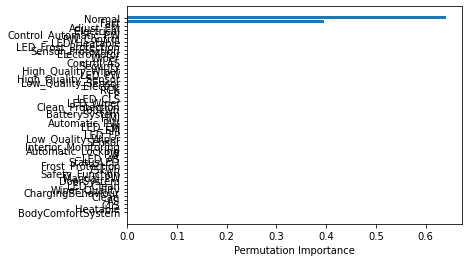

In [10]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(dataset_features.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"units_{i}", min_value=8, max_value=256, step=8),
                activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
            )
        )
    model.add(keras.layers.Dropout(rate=hp.Choice("dr", [0.25, 0.5])))
    model.add(keras.layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )
    return model

In [ ]:
tuner = kt.BayesianOptimization(
    hypermodel = build_model,
    objective="mean_squared_error",
    max_trials=10,
    overwrite=True,
    directory="my_tuner",
    project_name="feature_degradation",
)

In [ ]:
es = keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    patience=5,
    restore_best_weights=True
)

In [ ]:
tuner.search_space_summary()

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [ ]:
tuner.search(x_train, y_train, epochs=40, validation_data=(x_val, y_val), callbacks=[es])

In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
model = build_model(best_hps[0])
history = model.fit(x_train, y_train, batch_size=5, epochs=30, validation_data=(x_val, y_val),)

In [ ]:
def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.savefig("mse_per_epoch.png")

print("Defined the plot_the_loss_curve function.")

In [ ]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["mean_squared_error"]

In [ ]:
plot_the_loss_curve(epochs, mse)

In [ ]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [ ]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=5)

In [ ]:
print("Generate predictions for 3 samples\n")
test = x_test[:3]
print(test)
predictions = model.predict(test)
print("predictions:\n", predictions*labels_max)
print("real values \n", np.array([dataset['MTTF'][test.index]]).transpose())

In [209]:
predictions = model.predict(x_test)*labels_max

In [210]:
test_features = dataset_features.loc[x_test.index]
test_features['MTTF'] = predictions

In [211]:
mandatories = ['BodyComfortSystem','Electric', 'DoorSystem', 'BatterySystem', 'ElectroMotor', 'ChargingBehaviour', 'EM', 'PW', 'PW_Control', 'FP', 'Electrical', 'HMI', 'Wiper', 'Sensor', 'Wiper_Quality']

In [215]:
test_features = test_features.drop(mandatories, axis=1)

In [219]:
test_features['MTTF'].describe()

count    33.000000
mean      9.493692
std       0.734944
min       7.812185
25%       9.117134
50%       9.430896
75%       9.999500
max      10.954130
Name: MTTF, dtype: float64

In [216]:
high_mttf_configurations = test_features.loc[test_features['MTTF'] >= 9.5] 
low_mttf_configurations = test_features.loc[test_features['MTTF'] < 9.5] 

In [217]:
high_mttf_configurations

,100kwh,Clean_Protection,LED_Wiper,LED_CLS,RCK,Low_Quality_Sensor,Normal,High_Quality_Wiper,LED_PW,Security,...,StatusLED,LED_AS,Automatic_Locking,Interior_Monitoring,Fast,Low_Quality_Wiper,LED_FP,Automatic_PW,Adjust_EM,MTTF
85,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,10.405211
29,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,10.534847
95,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.311404
26,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,10.068798
83,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,9.999500
61,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.560136
46,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,10.439658
73,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,9.837645
50,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,10.954130
21,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,9.755718


In [218]:
low_mttf_configurations

,100kwh,Clean_Protection,LED_Wiper,LED_CLS,RCK,Low_Quality_Sensor,Normal,High_Quality_Wiper,LED_PW,Security,...,StatusLED,LED_AS,Automatic_Locking,Interior_Monitoring,Fast,Low_Quality_Wiper,LED_FP,Automatic_PW,Adjust_EM,MTTF
94,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.122157
65,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,9.240658
91,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,9.012002
69,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,9.210461
84,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,9.056029
75,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,9.074193
52,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,8.106525
63,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,9.447452
39,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,9.380907
59,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,9.291371
